# 신경망 학습 구현(매개변수값을 정하기 위해 경사하강법 사용---> 손실함수를 최소화하는 방법)

* 손실함수 
* 1. 평균 제곱 오차 (MSE)
* 2. 교차 엔트로피 오차

* 학습 알고리즘 구현
* 1. 미니배치 --> 훈련데이터에서 무작위로 일부를 가져옴
* 2. 기울기 산출  --> 각 가중치 매개변수의 기울기를 구한다.(기울기는 손실함수의 값을 작게하는 방향을 나타낸다.)
* 3. 매개변수 갱신 --> 가중치 매개변수를 기울기 방향으로 갱신한다.(경사하강법 같은 방법을 사용한다.)
* 4. 1~3단계를 반복한다.

In [ ]:
import numpy as np

# mse구하는 함수 구현
# y -> 예측값 , t -> 실제값
def mean_squared_error(y,t):
    return 0.5*np.sum((y-t)**2)

# 교차 엔트로피 오차 구하는 함수 구현
# 컴퓨터에서는 log안에 0이 들어가면 오류가 발생하기 때문에 아주 작은 수를 더하여 오류를 해결한다.
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [ ]:
# 예시
t = [0,0,1,0,0,0,0,0,0]
y = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0]


print('mse : {:.4f}'.format(mean_squared_error(np.array(y),np.array(t))))
print('cee : {:.4f}'.format(cross_entropy_error(np.array(y),np.array(t))))

In [ ]:
import os
os.getcwd()
os.chdir('C:/Users/174518/Desktop/c언어,파이선/파이썬 데이터/밑바닥부터시작하는딥러닝1/deep-learning-from-scratch-master')

In [ ]:
# 미니배치 훈련 구현
# 데이터의 양이 많으면 각각의 손실함수를 구하는 것은 힘드므로 미니배치를 통해 일부가 전체를 추정할 수 있게끔 만든다.

import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

In [ ]:
# w전체 훈련 데이터에서 무작위로 10장만 뽑기
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size,batch_size) # 전체 행에서 10개를 무작위로 뽑고 그 인덱스를 저장

# 미니 배치(전체에서 10개만 추출)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
# 배치 데이터를 지원하는 교차엔트로피 오차 함수 구현하기 !!
# 데이터가 하나인 경우와 배치로 묶여 입력될 경우 모두를 구현할 수 있도록 한다.

def cross_entropy_error(y,t):  # y는 예측값 ,  t는 정답 레이블
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]  # 미니배치 개수 지정
    return -np.sum(np.lo(y[np.arange(batch_size),t]))/batch_size
# y의 값들이 원핫인코딩으로 인해 배열이 변경되고 정답 레이블만 가지고도 교차 엔트로피를 구할 수 있기 때문에 정답 레이블만을 출력한다.

In [ ]:
# y[np.arange(batch_size),t]의 코드 간단한 예시 설명
batch_size = 3
row = np.arange(batch_size)
t = [2,4,0]
y = np.array([1,0,1,1,1,2,2,2,2,6,9,3,3,3,3]).reshape(3,5)
y[row,t]

In [ ]:
# 손실함수를 지표로 삼는 이유
# 손실함수 => 연속적으로 변함
# 정확도 => 불연속적으로 변함

# 수치 미분을 하는 함수 구현하기!!
# 함수의 기울기 출력
def numeric_diff(f,x):
    h = 1e-4
    return (f(x+h)-f(x-h))/(2*h)

In [ ]:
import matplotlib.pyplot as plt
def function_1(x):
    return 0.01*x**2 + 0.1*0.1

x = np.arange(0.0,20.0,0.1)
y = function_1(x)
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [ ]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [ ]:
# 편미분을 동시에 구할 수 있는 함수 구현하기
# 기울기들을 출력한다.

def numeric_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) 구하기
        x[idx] = tmp_val + h
        fxh1 = f(x)
        # f(x-h)구하기
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx] = tmp_val
        
    return grad

In [ ]:
numeric_gradient(function_2,np.array([3.0,4.0]))  # x1과 x2 각각의 기울기 구하기

In [ ]:
# 손실함수가 최소가 되게끔 하기 위해 경사하강법을 사용한다.
# 학습률은 수동적으로 정해주어야 한다.

# 0.01씩 계속 움직이는데 그 과정을 100번 반복한다.
def gradient_descent(f,init_x,lr=0.01,step_num = 100):
    x = init_x
    x_history = []
    
    for i in range(step_num):
        
        x_history.append(x.copy())
        
        grad = numerical_gradient(f,x)
        x -= lr*grad
    return x,np.array(x_history)

In [ ]:
# 경사하강법을 이용하여 x0^2 + x1^2 의 최소값을 구하라

def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([3.0,4.0])
x,x_history = gradient_descent(function_2,init_x,lr=0.01,step_num=100)

In [ ]:
plt.plot([-5,5],[0,0],'--b')
plt.plot([0,0],[-5,5],'--b')
plt.plot(x_history[:,0],x_history[:,1],'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [ ]:
# 신경망에서의 기울기
# 가중치 w를 변경했을 때 손실함수L이 얼마나 변화하는지를 나타낸다.

# 신경망에서 기울기 구하는 코드 구현
# class 사용하기!!

sys.path.append(os.pardir)

# 해당 경로에 있는 py파일 부르기
from common.functions import *  # common파일의 functions.py를 import해서 모든 함수를 사용할 수 있게끔 만든다.
from common.gradient import *

In [ ]:
# class를 만들어서 사용하기
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
    
    def predict(self,x):
        return np.dot(x,self.W)
    
    def loss(self,x,t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss

In [ ]:
net = simpleNet()
print('가중치 배열 : ',net.W)

x = np.array([0.6,0.9])
print('예측값 : ',net.predict(x))

t = np.array([0,0,1]) # 정답 레이블
net.loss(x,t)

In [ ]:
def f(w):
    return net.loss(x,t)
dw = numerical_gradient(f,net.W)  # 손실함수의 기울기 구하기
print(dw)

# 학습 알고리즘 구현

* 1단계 : 훈련데이터 미니배치   ---> 미니배치의 손실함수(교차엔트로피,mse) 값을 줄이는 것이 목표
* 2단계 : 각 가중치 매개변수의 기울기를 구한다.
* 3단계 : 매개변수 개선 ---> 경사하강법을 이용해 가중치 매개변수를 갱신한다.
* 4단계 : 1~3단계를 반복한다.

In [1]:
# 2층 신경망을 대상으로 신경망 구현  ---> 하나의 클래스로 구현

import sys, os
os.chdir('C:/Users/174518/Desktop/c언어,파이선/파이썬 데이터/밑바닥부터시작하는딥러닝1/deep-learning-from-scratch-master')
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import *

class twolayernet:
    
    def __init__(self,input_size,hidden_size,output_size,
                weight_init_std=0.01):   # 입력층의 노드수, 은닉층의 노드수, 출력층의 노드수, 초기 가중치
        # 가중치 초기화
        self.params={}
        self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self,x):  # x는 입력 값
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']
        
        a1 = np.dot(x,W1) + b1  # 입력값과 첫번째 가중치를 곱하고 편향 b를 더한 값
        z1 = sigmoid(a1)        # a1의 값을 활성화 함수(시그모이드)에 넣어서 값을 출력한다.
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        return y   # 최종 예측값 출력
    
    # x : 입력값 , t : 정답 레이블
    def loss(self,x,t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)  # 손실함수(교차엔트로피 오차)를 구한다.
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)  # one-hot encoding 형식으로 나오기 때문에 1인 위치를 출력한다.
        t = np.argmax(t,axis=1)
        
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W = lambda W:self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])
        
        return grads

In [2]:
# 미니배치를 이용해 mnist데이터를 2층 신경망에 집어넣어 구현

import numpy as np
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

train_loss_list = []

# 하이퍼 파라미터
iters_num = 10 #반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 할 개수
learning_rate = 0.1

# 신경망에 적용하기
network = twolayernet(input_size=784,hidden_size=50,output_size=10)

for i in range(iters_num):
    # 미니배치 출력하기(랜덤으로 100개 출력)
    batch_mask = np.random.choice(train_size,batch_size)  # 전체 train 데이터개수에서 100개를 랜덤으로 출력한다. (위치출력)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch,t_batch)
    
    # 매개변수 갱신
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate*grad[key]  # 각 매개변수를 경사하강법을 이용해 갱신시킨다.(갱신을 batch_size만큼 반복)
    
    # 학습 경과 기록
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

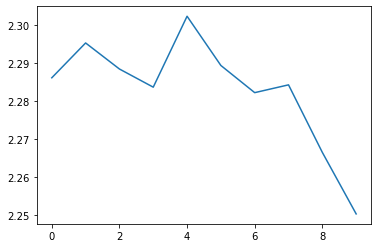

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.show()